In [6]:
import numpy as np
import pandas as pd
import featuretools as ft
import featuretools.variable_types as vtypes

In [7]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.preprocessing import LabelEncoder

In [11]:
train = pd.read_csv("train.csv").reset_index()
test = pd.read_csv("test.csv").reset_index()

In [12]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [13]:
train.head()

,index,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,0,140690,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,1,333291,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,2,129781,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,4,90569,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


In [14]:
es = ft.EntitySet(id = 'amexpert')

# Make an entity from the observations data
es = es.entity_from_dataframe(dataframe = train,
                              entity_id = 'amex',
                              index = 'index', 
                              time_index = 'DateTime')

In [15]:
es.normalize_entity(base_entity_id = 'amex',
                    new_entity_id = 'amexuser', 
                    index = 'user_id')
es

Entityset: amexpert
  Entities:
    amex [Rows: 463291, Columns: 16]
    amexuser [Rows: 150347, Columns: 2]
  Relationships:
    amex.user_id -> amexuser.user_id

In [16]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='amexuser',
                                       agg_primitives = ['min', 'max', 'mean', 
                                                         'count', 'sum'],
                                       trans_primitives = ['cum_mean', 'cum_sum'],
                                       max_depth = 1, n_jobs = -1, verbose = 1)
feature_matrix.head()

Built 45 features
EntitySet scattered to workers in 40.583 seconds
Elapsed: 01:26 | Remaining: 00:00 | Progress: 100%|██████████████████████████████████████████| Calculated: 11/11 chunks


tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "c:\program files\python36\lib\site-packages\tornado\gen.py", line 936, in error_callback
    future.result()
concurrent.futures._base.CancelledError
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:64915 remote=tcp://127.0.0.1:64861>


,MIN(amex.session_id),MIN(amex.campaign_id),MIN(amex.webpage_id),MIN(amex.product_category_1),MIN(amex.product_category_2),MIN(amex.user_group_id),MIN(amex.age_level),MIN(amex.user_depth),MIN(amex.city_development_index),MIN(amex.var_1),...,SUM(amex.campaign_id),SUM(amex.webpage_id),SUM(amex.product_category_1),SUM(amex.product_category_2),SUM(amex.user_group_id),SUM(amex.age_level),SUM(amex.user_depth),SUM(amex.city_development_index),SUM(amex.var_1),SUM(amex.is_click)
user_id,,,,,,,,,,,,,,,,,,,,,
4,4321,404347,53587,1,146115.0,11.0,5.0,2.0,NaN,0,...,404347,53587,1,146115.0,11.0,5.0,2.0,0.0,0,0
6,106452,405490,60305,3,NaN,3.0,3.0,3.0,3.0,1,...,405490,60305,3,0.0,3.0,3.0,3.0,3.0,1,0
19,538078,98970,6970,2,NaN,0.0,0.0,3.0,2.0,1,...,197940,13940,4,0.0,0.0,0.0,6.0,4.0,2,0
25,336652,359520,13787,2,NaN,2.0,2.0,3.0,4.0,1,...,720456,27574,6,0.0,4.0,4.0,6.0,8.0,2,0
26,349175,414149,45962,5,NaN,4.0,4.0,2.0,2.0,1,...,414149,45962,5,0.0,4.0,4.0,2.0,2.0,1,0


In [17]:
test_es = ft.EntitySet(id = 'test_amexpert')
test_es = test_es.entity_from_dataframe(dataframe = test,
                                        entity_id='amex', 
                                        index = 'index',
                                        time_index = 'DateTime')

In [18]:
test_es.normalize_entity(base_entity_id='amex',
                         new_entity_id = 'amexuser', 
                         index = 'user_id')
test_es

Entityset: test_amexpert
  Entities:
    amex [Rows: 128858, Columns: 15]
    amexuser [Rows: 66502, Columns: 2]
  Relationships:
    amex.user_id -> amexuser.user_id

In [ ]:
test_feature_matrix = ft.calculate_feature_matrix(feature_names, entityset=test_es, 
                                                   n_jobs = -1, verbose = 1)
test_feature_matrix.head()

In [6]:
target = 'is_click'

In [7]:
print(train.describe())

          session_id       user_id    campaign_id     webpage_id  \
count  463291.000000  4.632910e+05  463291.000000  463291.000000   
mean   285544.090725  5.460497e+05  308474.540069   29685.878994   
std    168577.345887  3.294625e+05  126517.101294   21542.053106   
min         2.000000  4.000000e+00   82320.000000    1734.000000   
25%    137856.500000  2.578550e+05  118601.000000   13787.000000   
50%    285429.000000  5.318010e+05  359520.000000   13787.000000   
75%    435535.500000  8.278490e+05  405490.000000   53587.000000   
max    595812.000000  1.141729e+06  414149.000000   60305.000000   

       product_category_1  product_category_2  user_group_id      age_level  \
count       463291.000000        97437.000000  445048.000000  445048.000000   
mean             3.072427       162753.345105       3.477396       2.782266   
std              1.304233        78743.742720       2.412889       1.069701   
min              1.000000        18595.000000       0.000000       0.00

In [8]:
train = train.replace("Female",0)
train = train.replace("Male",1)
test = test.replace("Female",0)
test = test.replace("Male",1)
le_product = LabelEncoder()
train['product_encoded'] = le_product.fit_transform(train['product'])
test['product_encoded'] = le_product.fit_transform(test['product'])
train = train.drop(['product'], axis=1)
test = test.drop(['product'], axis=1)
train = train.drop(['session_id','DateTime'], axis=1)
test = test.drop(['session_id','DateTime'], axis=1)
train

,user_id,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,product_encoded
0,858557,359520,13787,4,NaN,10.0,0.0,4.0,3.0,3.0,0,0,2
1,243253,105960,11085,5,NaN,8.0,0.0,2.0,2.0,NaN,0,0,2
2,243253,359520,13787,4,NaN,8.0,0.0,2.0,2.0,NaN,0,0,2
3,1097446,359520,13787,3,NaN,3.0,1.0,3.0,3.0,2.0,1,0,8
4,663656,405490,60305,3,NaN,2.0,1.0,2.0,3.0,2.0,1,0,2
5,509591,359520,13787,2,NaN,1.0,1.0,1.0,3.0,NaN,0,0,8
6,1091463,405490,60305,3,NaN,9.0,0.0,3.0,3.0,4.0,0,0,5
7,469098,360936,13787,3,NaN,4.0,1.0,4.0,3.0,4.0,0,0,2
8,611906,105960,11085,5,270915.0,NaN,NaN,NaN,NaN,NaN,0,0,7
9,418107,360936,13787,2,NaN,4.0,1.0,4.0,3.0,4.0,0,0,1


In [9]:
train['city_development_index'] = train['city_development_index'].fillna(train['city_development_index'].median())
train['product_category_2'] = train['product_category_2'].fillna(train['product_category_2'].median())
train['campaign_id'] = train['campaign_id'].fillna(train['campaign_id'].median())
train['webpage_id'] = train['webpage_id'].fillna(train['webpage_id'].median())
train['product_category_1'] = train['product_category_1'].fillna(train['product_category_1'].median())
train['user_group_id'] = train['user_group_id'].fillna(train['user_group_id'].median())
train['gender'] = train['gender'].fillna(train['gender'].median())
train['age_level'] = train['age_level'].fillna(train['age_level'].median())
train['user_depth'] = train['user_depth'].fillna(train['user_depth'].median())
train['var_1'] = train['var_1'].fillna(train['var_1'].median())
train

,user_id,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,product_encoded
0,858557,359520,13787,4,146115.0,10.0,0.0,4.0,3.0,3.0,0,0,2
1,243253,105960,11085,5,146115.0,8.0,0.0,2.0,2.0,2.0,0,0,2
2,243253,359520,13787,4,146115.0,8.0,0.0,2.0,2.0,2.0,0,0,2
3,1097446,359520,13787,3,146115.0,3.0,1.0,3.0,3.0,2.0,1,0,8
4,663656,405490,60305,3,146115.0,2.0,1.0,2.0,3.0,2.0,1,0,2
5,509591,359520,13787,2,146115.0,1.0,1.0,1.0,3.0,2.0,0,0,8
6,1091463,405490,60305,3,146115.0,9.0,0.0,3.0,3.0,4.0,0,0,5
7,469098,360936,13787,3,146115.0,4.0,1.0,4.0,3.0,4.0,0,0,2
8,611906,105960,11085,5,270915.0,3.0,1.0,3.0,3.0,2.0,0,0,7
9,418107,360936,13787,2,146115.0,4.0,1.0,4.0,3.0,4.0,0,0,1


In [10]:
test['city_development_index'] = test['city_development_index'].fillna(test['city_development_index'].median())
test['product_category_2'] = test['product_category_2'].fillna(test['product_category_2'].median())
test['campaign_id'] = test['campaign_id'].fillna(test['campaign_id'].median())
test['webpage_id'] = test['webpage_id'].fillna(test['webpage_id'].median())
test['product_category_1'] = test['product_category_1'].fillna(test['product_category_1'].median())
test['user_group_id'] = test['user_group_id'].fillna(test['user_group_id'].median())
test['gender'] = test['gender'].fillna(test['gender'].median())
test['age_level'] = test['age_level'].fillna(test['age_level'].median())
test['user_depth'] = test['user_depth'].fillna(test['user_depth'].median())
test['var_1'] = test['var_1'].fillna(test['var_1'].median())
test

,user_id,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,product_encoded
0,732573,404347,53587,1,82527.0,5.0,1.0,5.0,3.0,2.0,0,9
1,172910,118601,28529,3,82527.0,3.0,1.0,3.0,3.0,2.0,1,8
2,172910,118601,28529,4,82527.0,3.0,1.0,3.0,3.0,2.0,1,8
3,557318,118601,28529,5,82527.0,1.0,1.0,1.0,3.0,1.0,0,6
4,923896,118601,28529,5,82527.0,9.0,0.0,3.0,1.0,2.0,1,7
5,854182,118601,28529,4,82527.0,1.0,1.0,1.0,3.0,4.0,1,8
6,1101628,118601,28529,4,82527.0,2.0,1.0,2.0,3.0,2.0,1,3
7,1101628,118601,28529,5,82527.0,2.0,1.0,2.0,3.0,2.0,1,3
8,1088284,118601,28529,4,82527.0,2.0,1.0,2.0,3.0,1.0,0,8
9,972585,118601,28529,5,82527.0,2.0,1.0,2.0,3.0,2.0,0,7


In [11]:
predictors = [x for x in train.columns if x not in [target]]
predictors

['user_id',
 'campaign_id',
 'webpage_id',
 'product_category_1',
 'product_category_2',
 'user_group_id',
 'gender',
 'age_level',
 'user_depth',
 'city_development_index',
 'var_1',
 'product_encoded']

In [12]:
global str
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['is_click'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['is_click'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['is_click'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='gain')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9324
AUC Score (Train): 0.630694


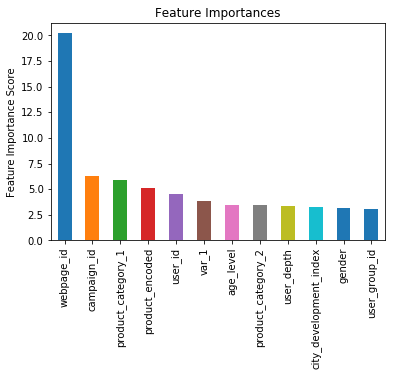

In [13]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, train, predictors)

In [14]:
param_test1 = {
 'max_depth':np.arange(3,10,2),
 'min_child_weight':np.arange(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.57237, std: 0.02025, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.57203, std: 0.02026, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.57226, std: 0.02005, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.57315, std: 0.01768, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.57291, std: 0.01760, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.57366, std: 0.01774, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.57173, std: 0.01528, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.57142, std: 0.01556, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.57277, std: 0.01535, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.57032, std: 0.01250, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.56842, std: 0.01357, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.56871, std: 0.01273, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 5

In [15]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.57383, std: 0.01873, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.57381, std: 0.01827, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.57395, std: 0.01869, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: 0.57350, std: 0.01761, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.57366, std: 0.01774, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.57346, std: 0.01706, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: 0.57311, std: 0.01609, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.57256, std: 0.01628, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.57308, std: 0.01610, params: {'max_depth': 6, 'min_child_weight': 6}],
 {'max_depth': 4, 'min_child_weight': 6},
 0.5739515787164103)

In [16]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9324
AUC Score (Train): 0.603542


([mean: 0.57395, std: 0.01869, params: {'min_child_weight': 6},
  mean: 0.57366, std: 0.01835, params: {'min_child_weight': 8},
  mean: 0.57365, std: 0.01847, params: {'min_child_weight': 10},
  mean: 0.57306, std: 0.01858, params: {'min_child_weight': 12}],
 {'min_child_weight': 6},
 0.5739515787164103)

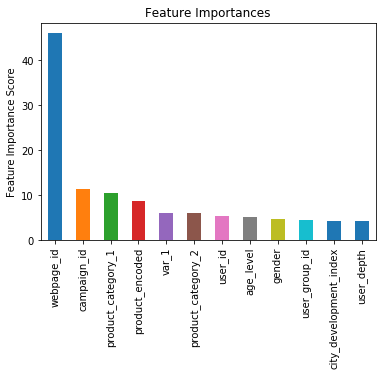

In [17]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_
modelfit(gsearch3.best_estimator_, train, predictors)
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

In [18]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.57395, std: 0.01869, params: {'gamma': 0.0},
  mean: 0.57342, std: 0.01812, params: {'gamma': 0.1},
  mean: 0.57313, std: 0.01836, params: {'gamma': 0.2},
  mean: 0.57323, std: 0.01827, params: {'gamma': 0.3},
  mean: 0.57375, std: 0.01854, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.5739515787164103)

c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9324
AUC Score (Train): 0.623429


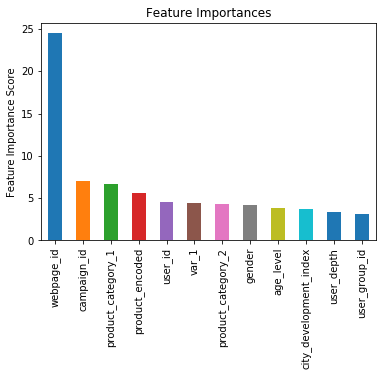

In [19]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

In [20]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.57341, std: 0.01811, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.57304, std: 0.01799, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.57351, std: 0.01834, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.57332, std: 0.01888, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.57326, std: 0.01790, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.57287, std: 0.01823, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.57379, std: 0.01871, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.57338, std: 0.01896, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.57319, std: 0.01798, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.57333, std: 0.01859, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.57378, std: 0.01812, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.57346, std: 0.01845, params: {'colsample_bytree': 0.8, 'subsample'

In [21]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.57375, std: 0.01839, params: {'reg_alpha': 1e-05},
  mean: 0.57367, std: 0.01870, params: {'reg_alpha': 0.01},
  mean: 0.57327, std: 0.01880, params: {'reg_alpha': 0.1},
  mean: 0.57373, std: 0.01818, params: {'reg_alpha': 1},
  mean: 0.57072, std: 0.02025, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.5737505465734529)

In [23]:
param_test7 = {
 'reg_alpha':[1e-05, 1e-04, 1e-03, 1e-06, 1e-07]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.57345, std: 0.01776, params: {'reg_alpha': 1e-05},
  mean: 0.57345, std: 0.01776, params: {'reg_alpha': 0.0001},
  mean: 0.57345, std: 0.01776, params: {'reg_alpha': 0.001},
  mean: 0.57345, std: 0.01776, params: {'reg_alpha': 1e-06},
  mean: 0.57345, std: 0.01776, params: {'reg_alpha': 1e-07}],
 {'reg_alpha': 0.001},
 0.5734534075421549)

c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9324
AUC Score (Train): 0.619776


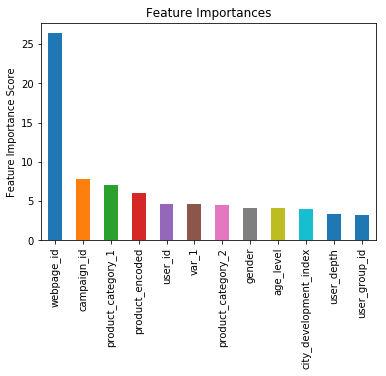

In [24]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.001,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

c:\program files\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9324
AUC Score (Train): 0.617565


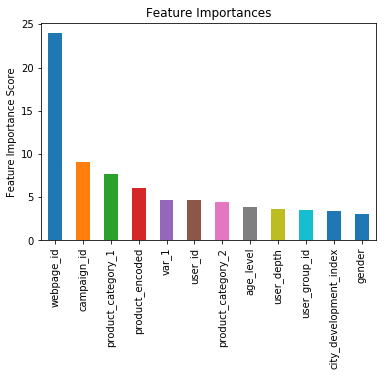

In [25]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)